# Series temporales con Prophet: Evolución del precio de las acciones de Walmart

Este notebook está extraído de este [post](https://medium.com/future-vision/intro-to-prophet-9d5b1cbd674e).

Los modelos de series temporales permiten predecir valores futuros basándonos en valores previamente observados, y aunque no son tan populares como otras técnicas son muy útiles en muchos ámbitos, como las finanzas, la estimación de carga de servidores informáticos, el negocio inmobiliario, la gestión de infraestructuras, etc.

La matemática que subyace a las series temporales es bastante compleja y se sale del ámbito de este curso, así que vamos a utilizar Prophet, una herramienta desarrollada por Facebook que se liberó al público en 2017, muy fácil de utilizar y a la vez muy potente:

*Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.*

Para conocer mejor los entresijos matemáticos de Prophet se puede consultar este [link](https://medium.com/future-vision/the-math-of-prophet-46864fa9c55a). En resumen, se trata de descomponer la serie temporal en tres componentes: la tendencia (*trend*), la estacionalidad (*seasonality*) y los festivos (*holidays*)

$y(t) = g(t) + s(t) + h(t) + e(t)$

$g(t)$ representa la tendencia, y se trata de los cambios no periódicos, que se modelizarán asumiendo una relación lineal o logística.

$s(t)$ es la estacionalidad, que representa cambios periódicos: semanales, mensuales, anuales, etc.

$h(t)$ es el efecto de los festivos, que pueden aparecer de manera irregular y tener una duración de 1 día o más.

$e(t)$ es el término de error, que representa cambios *idiosincrásicos* que no se pueden acomodar al modelo. Se asume que estos errores deben tener una distribución normal.

En este ejercicio vamos a utilizar Prophet para modelar el precio de las acciones de la compañía Walmart en la bolsa de Nueva York. Comenzamos como siempre cargando las librerías que necesitaremos, pero primero hay que asegurarse de que Prophet está correctamente instalado en nuestro espacio de trabajo. Hay que tener cuidado, porque existen incompatibilidades entre algunos paquetes, hay que asegurarse de que tenemos instalados exactamente las versiones que se indican:

In [1]:
# !pip install fbprophet==0.5
# !pip install holidays==0.9.12
# !pip install pandas==0.25.3

In [2]:
import warnings
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import time

# don't do this 
warnings.filterwarnings('ignore')
# "high resolution"
%config InlineBackend.figure_format = 'retina'

Descargamos el dataset desde el repo del curso y lo cargamos en el espacio de trabajo de Colab:

In [3]:
##### DOWNLOAD DATASET. ONLY IN COLAB !!!
!wget -P ./../data/ https://raw.githubusercontent.com/CenticMurcia/curso-ciencia-datos/master/data/WMT.csv

--2020-02-19 18:45:37--  https://raw.githubusercontent.com/CenticMurcia/curso-ciencia-datos/master/data/WMT.csv
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.128.133, 151.101.64.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[151.101.192.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 792118 (774K) [text/plain]
Guardando como: “./../data/WMT.csv.5”

WMT.csv.5           100%[===================>] 773,55K  1,90MB/s    en 0,4s    

2020-02-19 18:45:38 (1,90 MB/s) - “./../data/WMT.csv.5” guardado [792118/792118]



In [4]:
# load walmart ($wmt) historical stock data
wmt = pd.read_csv('./../data/WMT.csv')

Los datos se han extraído de Yahoo Finance ([link](https://finance.yahoo.com/quote/WMT/history?period1=83574000&period2=1562137200&interval=1d&filter=history&frequency=1d)), son datos reales de la evolución del precio en dólares de las acciones de Walmart Inc. (WMT) en la bolsa de Nueva York (NYSE) entre el 25 de agosto de 1972 y el 2 de julio de 2019. Vamos a hacer un breve EDA:

In [5]:
# what's the sitch
wmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11815 entries, 0 to 11814
Data columns (total 7 columns):
Date         11815 non-null object
Open         11815 non-null float64
High         11815 non-null float64
Low          11815 non-null float64
Close        11815 non-null float64
Adj Close    11815 non-null float64
Volume       11815 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 646.3+ KB


In [6]:
# tell me about it
wmt.describe()

,Open,High,Low,Close,Adj Close,Volume
count,11815.000000,11815.000000,11815.000000,11815.000000,11815.000000,1.181500e+04
mean,29.942336,30.226543,29.658511,29.948090,24.052813,7.510762e+06
std,29.802418,30.051176,29.566506,29.811830,26.403796,6.327371e+06
min,0.015625,0.015625,0.014404,0.015625,0.005798,0.000000e+00
25%,1.265625,1.281250,1.253906,1.265625,0.513472,3.753600e+06
50%,13.718750,13.843750,13.562500,13.687500,8.964169,6.263200e+06
75%,54.000000,54.570000,53.500000,54.000000,40.389094,9.515000e+06
max,111.489998,112.220001,111.029999,111.599998,111.599998,1.318336e+08


In [7]:
# let's see
wmt.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-08-25,0.063477,0.064697,0.063477,0.064453,0.023768,2508800
1,1972-08-28,0.064453,0.064941,0.064209,0.064209,0.023678,972800
2,1972-08-29,0.063965,0.063965,0.063477,0.063477,0.023408,1945600
3,1972-08-30,0.063477,0.063477,0.062988,0.063477,0.023408,409600
4,1972-08-31,0.062988,0.062988,0.062500,0.062500,0.023047,870400


Vemos que en total tenemos precios de 11,815 días de sesión bursátil, la fecha se encuentra en la variable *Date* y el precio de la acción se encuentra en la variable *Adj Close*. Estas son las dos variables que usaremos con Prophet, las demás no las utilizaremos. Debemos formatear los datos para poder usarlos, cambiando el nombre de las columnas y convirtiendo las fechas de texto a *datetime*:

In [8]:
# forege new dataframe with date and adjusted closing price
wmt = wmt[['Date','Adj Close']]
# adjust column names for prophet compliance
wmt.columns = ['ds','y']
# convert dates from string to datetime
wmt.ds = pd.to_datetime(wmt.ds)

# display adjustments
wmt.tail()

,ds,y
11810,2019-06-26,110.160004
11811,2019-06-27,110.099998
11812,2019-06-28,110.489998
11813,2019-07-01,110.620003
11814,2019-07-02,111.599998


Vamos a echar un vistazo a los datos representando gráficamente cómo varía el precio de las acciones con el tiempo:

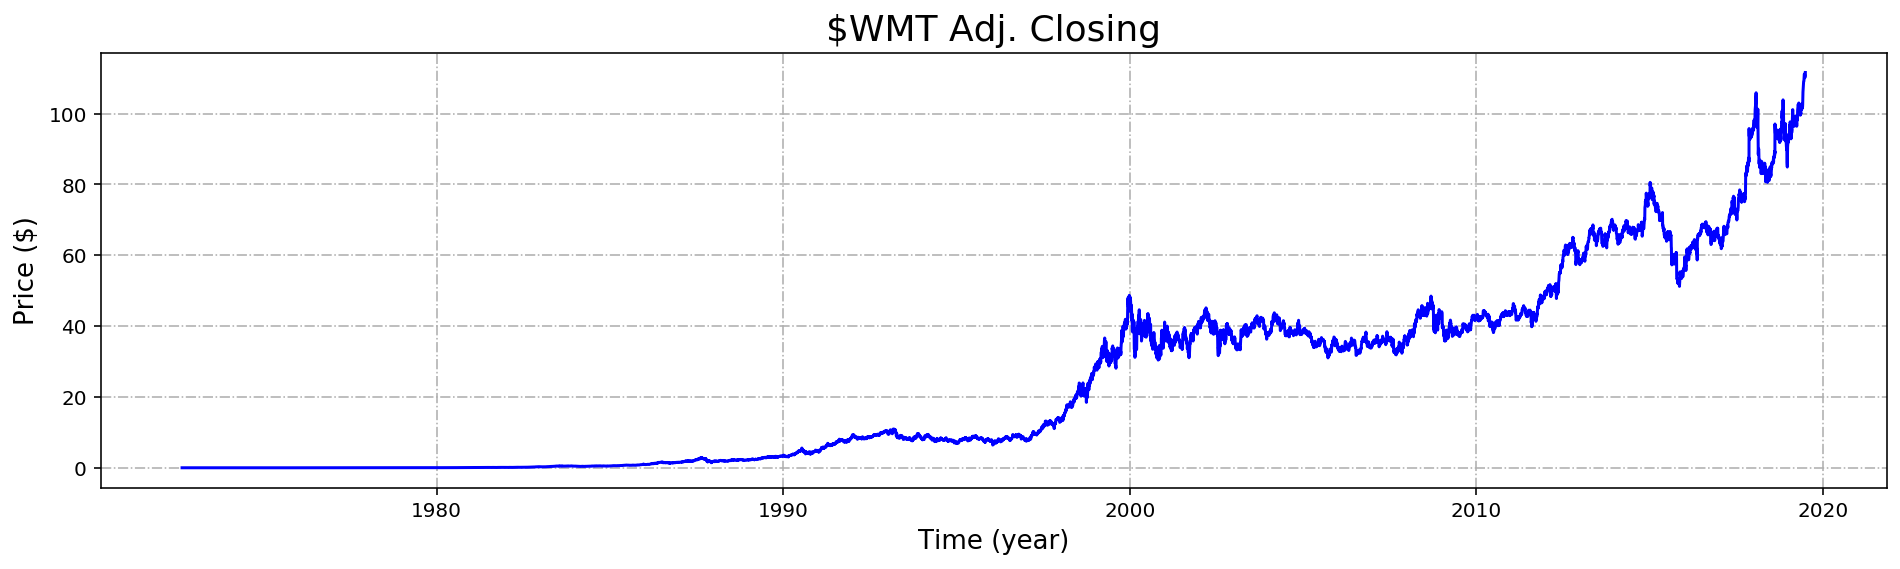

In [9]:
# frame up w/ grid
plt.figure(figsize=(16,4))
plt.grid(linestyle='-.')

# sketch in data
plt.plot(wmt.ds, wmt.y, 'b')

# set title & labels
plt.title('$WMT Adj. Closing', fontsize=18)
plt.ylabel('Price ($)', fontsize=13)
plt.xlabel('Time (year)', fontsize=13)

# display graph
plt.show()

Vemos que en general el precio de las acciones aumenta constantemente, aunque a velocidad variable, unas veces muy rápido y otras más lento. Puntualmente se puede producir algún descenso pronunciado. Vamos ahora a crear un modelo de Prophet que intente reproducir este comportamiento. Comenzamos definiendo el modelo, luego lo ajustamos a nuestros datos con **fit**, y por último realizamos una predicción. Como entrada para el método **fit** necesitamos un DataFrame con dos columnas:

- **ds** (datestamp) debe ser de tipo **date** o **datetime**.
- **y** es el valor (numérico) a predecir.

Nuestros datos ya cumplen estos requisitos, así que procedemos a crear el modelo, entrenarlo y predecir con él el valor de las acciones en los próximos 5 años:

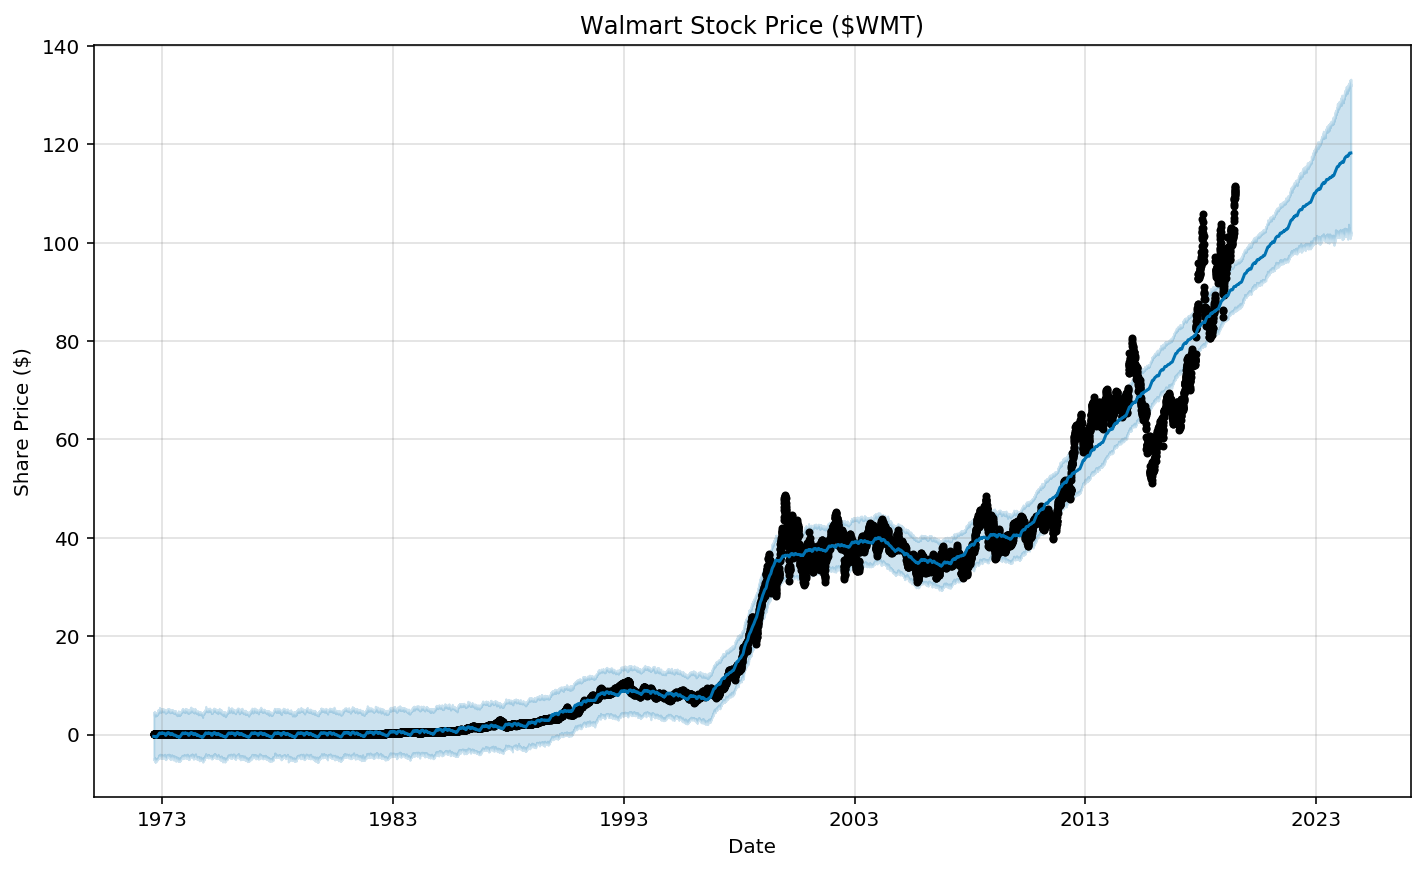

46.28962421417236

In [10]:
myTime = time.time()

# set prophet model 
prophet = Prophet(changepoint_prior_scale=0.05, daily_seasonality=False,)

# fit $wmt data to model
prophet.fit(wmt)

# build future dataframe for 5 years
build_forecast = prophet.make_future_dataframe(periods=365*5, freq='D')

# forecast future df with model
forecast = prophet.predict(build_forecast)

# plot forecasts
prophet.plot(forecast, xlabel='Date', ylabel='Share Price ($)')
plt.title('Walmart Stock Price ($WMT)')
plt.show()

time.time() - myTime

En esta gráfica los puntos negros indican los verdaderos valores de los precios de las acciones, la línea azul son los precios predichos por Prophet, y la zona azul claro es el intervalo de confianza de esas predicciones. Estos intervalos no enmarcan exactamente los precios verdaderos, solo indican la incertidumbre de las predicciones y si existe *overfitting*. Ahora vamos a desglosar los distintos componentes del modelo:

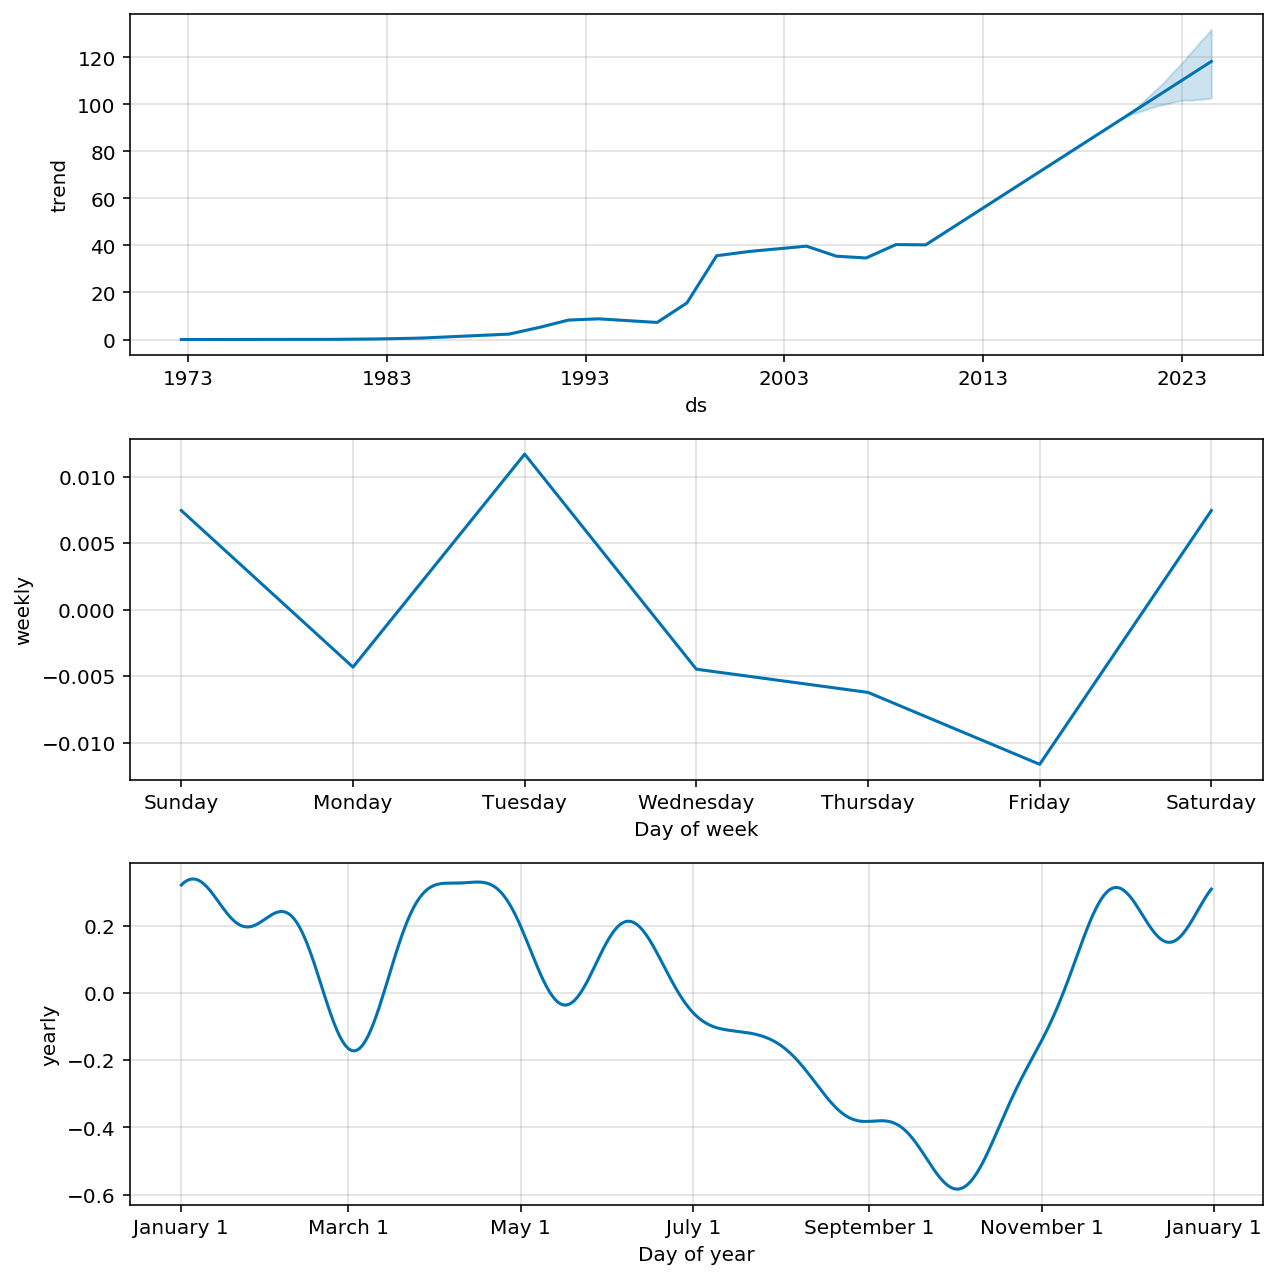

In [11]:
# tell us more about the forecast
components = prophet.plot_components(forecast)

Vemos que en general los precios de las acciones suelen alcanzar un valor máximo los martes, que caen de precio en octubre, y que su valor aumenta sistemáticamente con el tiempo, aunque a un ritmo variable. Sería por tanto una buena táctica comprar acciones de Walmart cualquier viernes de octubre y venderlas cualquier martes de enero para maximizar los beneficios. Y todas estas conclusiones las hemos obtenido con unas pocas líneas de código.

Podemos comparar ahora las predicciones que hemos hecho con los valores actuales en la bolsa de Nueva York ([link](https://finance.yahoo.com/quote/WMT/history?period1=83574000&period2=1562137200&interval=1d&filter=history&frequency=1d)):

In [12]:
# narrow selection to dates past initial dataframe
future_preds = forecast.loc[forecast.ds>'2020-02-15']
# select date, prediction, lower and upper limits 
future_preds = future_preds[['ds','yhat','yhat_lower','yhat_upper']]
# display some predictions
future_preds.head(10)

,ds,yhat,yhat_lower,yhat_upper
12043,2020-02-16,94.718949,89.724449,99.611712
12044,2020-02-17,94.698441,90.127765,99.455620
12045,2020-02-18,94.704347,90.081589,99.740816
12046,2020-02-19,94.677127,89.781426,99.597320
12047,2020-02-20,94.663784,90.252083,99.651904
12048,2020-02-21,94.646695,90.010650,99.564739
12049,2020-02-22,94.654459,89.578807,99.260690
12050,2020-02-23,94.644004,89.884331,99.290644
12051,2020-02-24,94.623097,89.819989,99.104006
12052,2020-02-25,94.631719,90.086990,99.221642


Vemos que nuestras predicciones están infravaloradas, el precio actual es significativamente mayor (95 dólares predichos vs. 118 dólares reales aproximadamente). Las predicciones de nuestro modelo, aunque no están mal, no son tan precisas como nos hubiese gustado. Pero no necesitamos esperar hasta que llega el día para comprobar si nuestra predicción es correcta, podemos hacer una estimación de la precisión usando un procedimiento de validación cruzada incorporado en Prophet, en el que se hacen predicciones a cierto horizonte (por ejemplo 365 días) cada cierto intervalo (por ejemplo 180 días) trascurrido cierto periodo de tiempo (por ejemplo 730 días). Vamos a aplicar este procedimiento sobre 30 años de datos validando predicciones s 365 días cada 180 días:

In [13]:
myTime = time.time()

# OJO! POR ACORTAR EN LUGAR DE 30 AÑOS VAMOS A USAR 45, 
# EN LUGAR DE 10950 DÍAS PONDREMOS 16425
# SI NO LO HACÉIS, TARDARÁ MÁS DE 10 MINUTOS EN ACABAR
wmt_cv = cross_validation(prophet, initial='16425 days', period='180 days', horizon = '365 days')

time.time() - myTime

INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-01-03 00:00:00 and 2018-07-02 00:00:00


45.736143827438354

Echamos un vistazo al resultado de la validación y determinamos la precisión:

In [14]:
# example output 
wmt_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-01-04,77.434005,73.246264,81.372739,96.200760,2018-01-03
1,2018-01-05,77.412893,73.378502,81.502057,96.770966,2018-01-03
2,2018-01-08,77.349653,73.317545,81.146013,98.201317,2018-01-03
3,2018-01-09,77.335616,73.173019,81.224658,97.022247,2018-01-03
4,2018-01-10,77.303947,73.453351,81.452322,96.326385,2018-01-03


In [15]:
# how's the preformance  
wmt_pm = performance_metrics(wmt_cv)

In [16]:
# final accuracy
wmt_pm.tail(3)

,horizon,mse,rmse,mae,mape,coverage
320,362 days,296.371032,17.215430,15.987949,0.156297,0.02
321,364 days,299.611951,17.309302,16.023369,0.156500,0.02
322,365 days,309.017660,17.578898,16.253594,0.158109,0.02


Se recomienda usar la métrica MAPE (*Mean Absolute Percentage Error*, error porcentual absoluto medio) para determinar el error, así que la vamos a representar gráficamente:

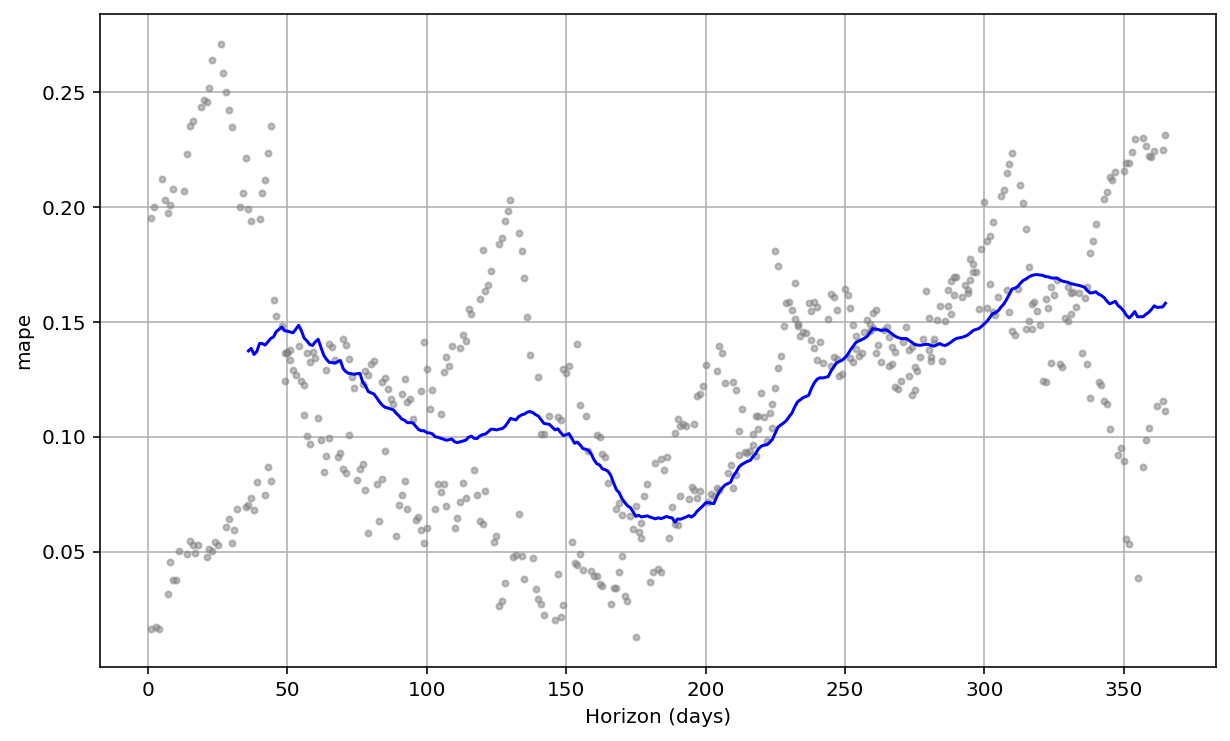

In [17]:
# visualize mape across horizon (continued sort)
fig = plot_cross_validation_metric(wmt_cv, metric='mape')

Vemos que se estima un error de entre el 10% y el 15 en las predicciones, lo que cuadra con nuestras comprobaciones anteriores. Y todo ello casi sin ajustar el modelo, usando los parámetros por defecto.

Para más información se puede consultar [aquí](https://doi.org/10.7287/peerj.preprints.3190v2) el artículo original de Facebook con todos los detalles de los algoritmos.